### A Start at some correspondence analysis like I did for Corpus Linguistics

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
#stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')

### [Skip to load previously saved contingency table](#loadctab)

In [ ]:
# Load the two data sets needed
# string encodings to try utf_8, iso8859_15
facetPlotData = pd.read_csv('facetPlotData.csv')
df = pd.read_csv('fullEmotionData.csv', encoding='utf_8') # apostrophes aren't being read correctly
# Pandas reads date as string, cast to datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
facetPlotData['date'] = pd.to_datetime(facetPlotData['date'], format='%Y-%m-%d')
facetPlotData.shape # Should be (3000, 4) 

<A HREF="https://regexr.com/">RegExr</A>

In [ ]:
#Load SpaCy English Model
nlp = en_core_web_md.load()

In [ ]:
punc = '''!()-[]{};:"\,<>./?—@#$%^&*_~â'''
sources = ['text_oba', 'text_nyt', 'text_wsj']
for source in sources:
    for i in range(len(df[source])):
        nopunc = ''.join([letter if letter not in punc else " " for letter in df[source][i] ])
        df.loc[i, source] =re.sub(' +', ' ', nopunc).replace('\n','').replace("' ", " ").strip()

In [ ]:
# Tells pandas to print all the text when printing an article or speech not just a 50 character preview
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

In [ ]:
# Function to find date of max emoValue for a particular source and emotion
def findmax(sourcefm, emofm, printyn):
    '''
    Function to print date of maximum value of subset of data
    # sourcefm - source name (oba, nyt, wsj)
    # emofm - emotion name (fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation)
    # printyn = 0 or 1 to print text
    '''
    find = facetPlotData[(facetPlotData['source'] == sourcefm) & (facetPlotData['emotion'] == emofm)]
    result = find.loc[find['emoValue'].idxmax()]
    date = result['date'].strftime('%Y-%m-%d')
    print(date, round(result['emoValue'], 4))
    if printyn == 1:
        text = 'text_' + sourcefm
        print(df.query('date == @date')[text])

In [ ]:
findmax('oba', 'positive', 1)

### <A HREF="https://www.nltk.org/index.html">NLTK Documentation</A> <A HREF="https://www.tomaarsen.com/nltk/api/nltk.html">API reference</A>

In [ ]:
# Run this if you want to remove stop words before creating contingency table
kaggle_file = open("./word_lists/kaggle_stopwords.txt", "r")
kaggle_data = kaggle_file.read()
kaggle_list = [word for word in kaggle_data.split('\n')]
kaggle_file.close()
my_list = ['thats', 'just', 'im', 'did', 'thing', 'mr', 'al', 'thank', 'okay', 'thank','thanks', 
           'question', 'joshua', 'president', 'obama', 's', 't', 'L', 'B', 'G', 'T', 'd', 've']
stop_list = list(set(kaggle_list) | set(my_list))
stop_words = text.ENGLISH_STOP_WORDS.union(stop_list)

' '.join([word for word in df['text_oba'][43].split() if word.lower() not in ENGLISH_STOP_WORDS])

In [ ]:
# Create a frequency list of all words in all Obama speeches

# How to flatten a list
#[item for sublist in list_of_lists for item in sublist]

freqlist = nltk.FreqDist([word.lower() for text in df['text_oba'] for word in text.split()])
freqlist

In [ ]:
sorted(dict(freqlist).items(),key=lambda x:x[1], reverse=True)[:20]

In [ ]:
# list of all the words in the freqlist which is from all 100 documents
words = list(set(dict(freqlist).keys()))
# was getting a weird error below, just making sure all are strings, no numbers
words = [str(word) for word in words] 

### Create Contingency Table - counts of all words in all the documents

In [ ]:
# Get counts of all words in 'words' for each speech/article
# I'm doing this the slow way so I can be sure the results are correct.
# I was getting weird numbers using other methods, 
#    like using sklearn countvectorizer I was getting 2900 for 'deepwater' when it should be 4
# I realize this is ugly
counts = []
for i in range(len(df['text_oba'])):
    sums = []
    for word in words:
        summ = 0
        for docword in df['text_oba'][i].split():
            if docword == word:
                summ+=1
        sums.append(summ)
    counts.append(sums)

In [ ]:
# Oh man, this is so ugly, just brute force, no style or class. Oh well, it works!
totalcounts = []
for i in range(len(words)):
    summ = 0
    for j in range(len(counts)):
        summ += counts[j][i]
    totalcounts.append(summ)      

In [ ]:
# total count of 'deepwater' should be 4 from one speech
word = 'deepwater'
[vectr[words.index(word)] for vectr in counts if vectr[words.index(word)]>0]

In [ ]:
# Contingency table
filenames = [name.replace('.txt', '') for name in df['file']]
conttab = pd.DataFrame(counts, columns = words, index = filenames, dtype='int')

In [ ]:
conttab.loc['sum',:] = conttab.sum(axis=0)

In [ ]:
conttab

In [ ]:
# And here is the full Contingency Table, sorted with most frequent words first
conttab.sort_values(by='sum', axis=1, ascending=False, inplace=True)
conttab.drop('sum', inplace=True)
conttab

In [ ]:
# Save table so we don't have to do this again
#conttab.to_csv('obamaContingencyTable.csv')

<a id='loadctab'>Load Contingency Table</a>

In [17]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab_oba = pd.read_csv('obamaContingencyTable_noSW_150.csv',index_col=0)
ctab_gwb = pd.read_csv('GWB_ContingencyTable_noSW_150.csv', index_col=0)
# Shorten row index names to date only
ctab_oba = ctab_oba.rename(index = lambda x: x[0:10])
ctab_gwb = ctab_gwb.rename(index = lambda x: x[0:10])

In [18]:
# Let's look at the 150 most common words
ctabshort_oba=ctab_oba.iloc[:, : 150].copy(deep=True)
ctabshort_gwb=ctab_gwb.iloc[:, : 150].copy(deep=True)

In [19]:
ctab_oba = None
ctab_gwb = None

<A HREF="https://github.com/MaxHalford/prince#correspondence-analysis-ca">Prince Correspondence Analysis</A>

In [30]:
cao = prince.CA(n_components=2,
               n_iter=10,
               copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)
cag = prince.CA(n_components=2,
               n_iter=10,
               copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)

In [31]:
ctabshort_oba.columns.rename('words', inplace=True)
ctabshort_gwb.columns.rename('words', inplace=True)
ctabshort_oba.index.rename('speeches', inplace=True)
ctabshort_gwb.index.rename('speeches', inplace=True)
ca_oba = cao.fit(ctabshort_oba)
ca_gwb = cag.fit(ctabshort_gwb)

In [22]:
ca_oba.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.144,10.74%,10.74%
1,0.090,6.72%,17.46%


<A HREF="https://maxhalford.github.io/prince/ca/">Prince correspondence analysis</A>

In [25]:
cao.plot(
    ctabshort_oba,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [32]:
# ca.plot_coordinates is from the Prince multivariate library
ax = cao.plot_coordinates(X=ctabshort_oba,
                         ax=None,
                         figsize=(10, 10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)

AttributeError: 'CA' object has no attribute 'plot_coordinates'

<A HREF="https://matplotlib.org/cheatsheets/cheatsheets.pdf">Matplotlib basic cheat sheet</A><BR>
    <A HREF="https://matplotlib.org/cheatsheets/">other matplotlib cheat sheets</A>

From NRC analysis the speech with particularly high anger value was 2015-01-08
and particularly high positive value on 2014-03-07

/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


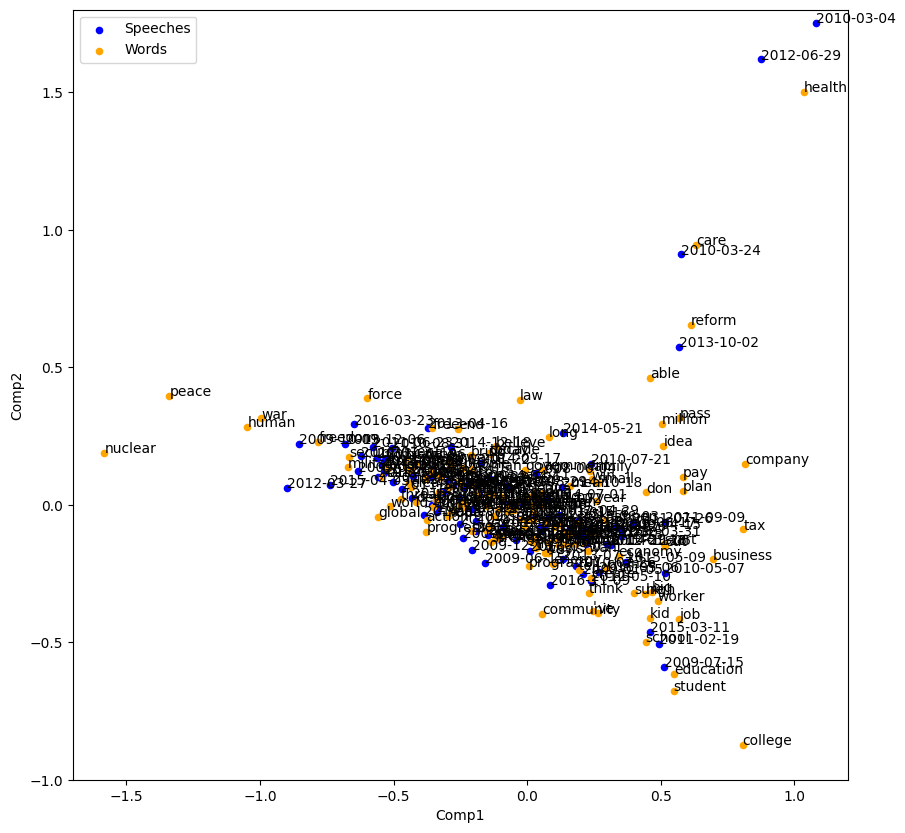

In [33]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=cao.row_coordinates(ctabshort_oba)
df1.columns=['Comp1', 'Comp2']
df2=cao.column_coordinates(ctabshort_oba)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 1.8])
plt.legend(['Speeches', 'Words'])
plt.show()

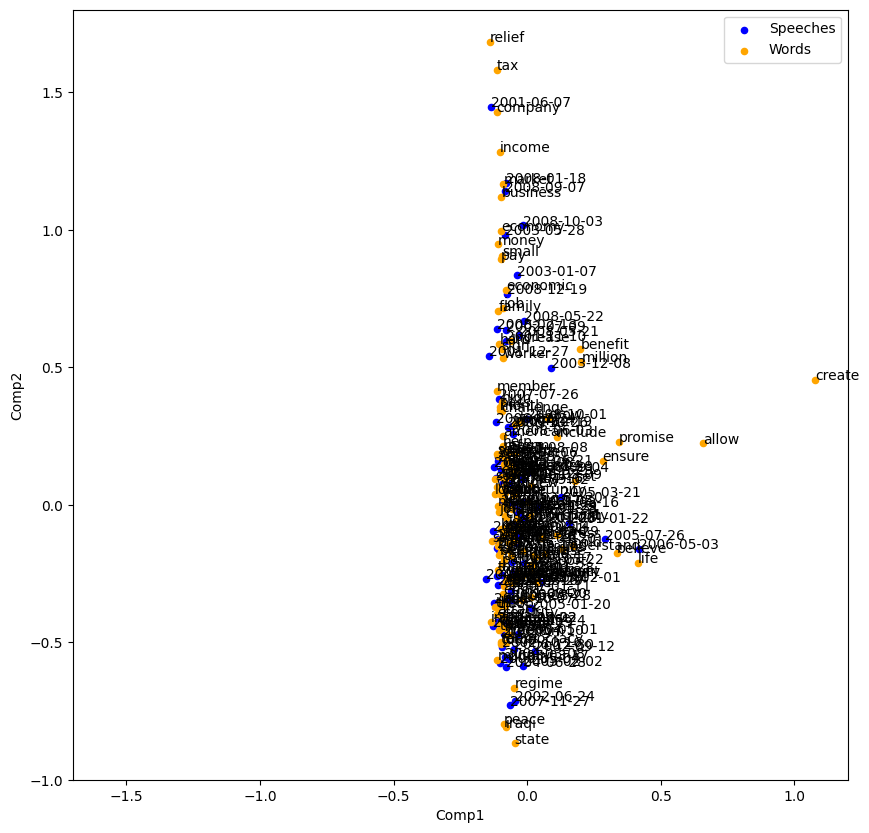

In [34]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=cag.row_coordinates(ctabshort_gwb)
df1.columns=['Comp1', 'Comp2']
df2=cag.column_coordinates(ctabshort_gwb)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 1.8])
plt.legend(['Speeches', 'Words'])
plt.show()

### Try correspondence analysis on a pre-selected list of words

In [ ]:
# Load words from file
# topic words from topic modeling: "./word_lists/topic-words.txt"
# a custom list: "./word_lists/customlist.txt"
# common adjective: "./word_lists/adjectives.txt"
# common adverbs: "./word_lists/adverbs.txt"
# function words: "./word_lists/function-words.txt"
# hope words: "./word_lists/hope_words.txt"
wordList = pd.read_csv("./word_lists/adverbs.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])
# lemmatize word list with spacy
#nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
#for i, word in enumerate(wordList):
#    wordList['word'][i] = " ".join([token.lemma_ for token in nlp(word)])
#wordList.drop_duplicates(inplace=True)

In [ ]:
# Make a short contingency list using topic words
ctabshort2 = ctab.loc[ : , [col for col in ctab.columns if col in list(wordList['word'])]]

#ctabshort2.describe()
#print(ctabshort2.isnull().sum())

# Keep it to the most common 150 words or length of word list if shorter
num_words = min(150, len(wordList)-1)

if np.shape(ctabshort2)[1] > num_words:
    ctabshort2=ctabshort2.iloc[:, : num_words]
    
ctabshort2.columns.rename('words', inplace=True)
ctabshort2.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort2)

In [ ]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort2)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort2)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

#plt.xlim([-0.5, 1.5])
#plt.ylim([-0.6, 0.4])
plt.show()

### Now try using the most frequent 150 words after removing the Kaggle 700 stop words

In [ ]:
# Load words from file
# Kaggle stop words: "./word_lists/kaggle_stopwords.txt"
wordList = pd.read_csv("./word_lists/kaggle_stopwords.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [ ]:
number_of_words = 400
# Make a short contingency list removing the Kaggle stop words
ctabshort3 = ctab.loc[ : , [col for col in ctab.columns if col not in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort3)[1] > number_of_words:
    ctabshort3=ctabshort3.iloc[:, : number_of_words]
    
ctabshort3.columns.rename('words', inplace=True)
ctabshort3.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort3)

In [ ]:
date1 = '2015-01-08' # date 1 is red X
date2 = '2011-05-02' # date 2 is green pentagon
df1=ca.row_coordinates(ctabshort3)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort3)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches - blue
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words - orange
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-0.9, -0.4])
plt.ylim([0.1, 0.4])
plt.show()